- Update log
  - 6.12
    - 增加了通过均值方差生成theta的theta_gen，但发现很难精准控制值
      - 预计仍旧采用随机采样分析  
      - 可以考虑在特定区间，如theta in  [0.01,0.1]，进行分析
    - TS算法完工
    - 可视化
      - 统计了对于无明显特征的theta组，采用1000量级的先验参数误差较小（效果最好）的次数最多
    -  可能的目标
       -  直接将1000量级的实验结果取出，和另外两个算法的最优比较（只比较均值，所以是柱状图；只比较排名第一次数，所以也是柱状图）
       -  将theta的区间从[0,1]转换为[0.001,0.1]，再度进行一个完整流程的探索

## Theta Generate & ThetaSequence Definition

In [3]:
## specific_theta_geneta
import numpy as np
import matplotlib.pyplot as plt

class ThetaSequence:
    def __init__(self, seq: np.ndarray, n_elements: int):
        self.seq = seq
        self.n_elem = n_elements
        self.mean = np.mean(seq)
        self.var = np.var(seq)
        self.max_theta = np.max(seq)

## randomly generate
def generate_theta_sequence_set(n_elem, n_sets):
    theta_seq_set = []
    for _ in range(n_sets):
        theta_seq = ThetaSequence(np.random.uniform(0, 1, size=n_elem), n_elem)
        theta_seq_set.append(theta_seq)
    return np.array(theta_seq_set)

## 用theta组的数值特征，判断不同参数对不同特征的适应性
## 每个theta 跑200次，每次5000下摇杆

## 数值大小随意，数值特征重要
# 均值0.05为跨度，标准差1/20为跨度

## 使用固定的均值、标准差，生成n和数据（theta_seq）
def specific_theta_generate(mean, std_dev, n):
  # np.random.seed(0)  # 设置随机种子以确保结果可复现
  flag = False
  while not flag:
    flag = True
    theta_array = np.random.normal(loc=mean, scale=std_dev, size=n)
    for i in theta_array:
      if i <= 0 or i >=1:
        flag = False
        break
  return ThetaSequence(theta_array,n)

## 静均值，动标准差
def theta_generate_static_mean_rolling_std_dev(size, mean, start_std_dev, end_std_dev, span):
  theta_set = []
  for rolling_std_dev in np.arange(start_std_dev, end_std_dev, span):
     theta_set.append(specific_theta_generate(mean, rolling_std_dev, size))
  return np.array(theta_set)

## 静标准差，动均值
def theta_generate_static_std_dev_rolling_mean(size, std_dev, start_mean, end_mean, span):
  theta_set = []
  for rolling_mean in np.arange(start_mean, end_mean, span):
     theta_set.append(specific_theta_generate(rolling_mean, std_dev, size))
  return np.array(theta_set)





In [4]:
## Test Field

# 已知的均值和方差
known_mean = 0.5
known_var = 1/6


print(theta_generate_static_mean_rolling_std_dev(3,known_mean,known_var,0.9,0.1)[2].mean)



0.64621128850302


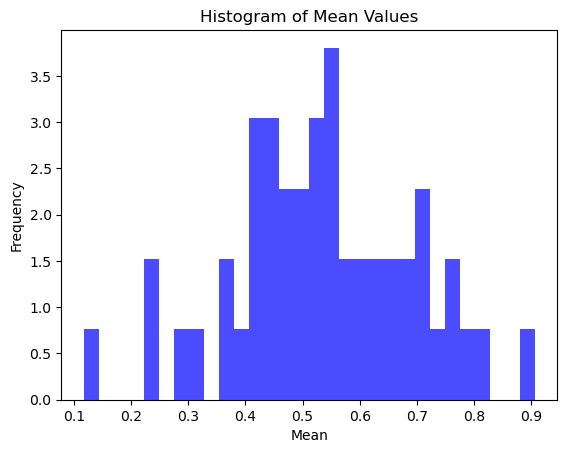

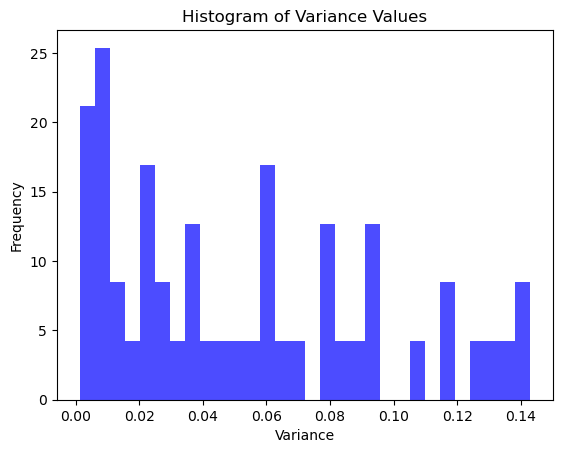

In [5]:
## Gen Field
n_elem = 3
n_sets = 50

theta_seq_set = generate_theta_sequence_set(n_elem, n_sets)

# 提取 ThetaSequence 对象的 mean 属性作为数据序列
mean_values = [theta_seq.mean for theta_seq in theta_seq_set]
plt.hist(mean_values, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Values')
plt.show()

# 提取 ThetaSequence 对象的 variance 属性作为数据序列
variance_values = [theta_seq.var for theta_seq in theta_seq_set]
plt.hist(variance_values, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Variance Values')
plt.show()

## Beta Prio Gen

In [6]:
def beta_prio_generate(theta_seq_set: np.ndarray, min_n_trails: int):
  para_set_min = []
  para_set_10_min = []
  para_set_100_min = []
  for theta_seq in theta_seq_set:
    ## 以下针对一组thetaSeq
    for k in range(3):
      para = []
      for theta in theta_seq.seq:
        res = np.random.binomial(1, theta, (10 ** k)*min_n_trails)
        para.append([np.sum(res), (10 ** k)*min_n_trails - np.sum(res)])
      if k==0:
        para_set_min.append(para)
      elif k==1:
        para_set_10_min.append(para)
      else:
        para_set_100_min.append(para)

  return np.array(para_set_min), np.array(para_set_10_min), np.array(para_set_100_min)
  
## 性能优化：所有数组先申请好成1，最后再增加
para_exp_0, para_exp_1, para_exp_2 = beta_prio_generate(theta_seq_set, min_n_trails=10)

## 针对性的一次TS

I'm calculating, plz wait.
3925.4 4795.0 3867.4 3872.8
   delta: 869.6 -58.0 -52.6
Theta-Var: 0.1055   best-arm: 3

3759.0 3388.4 4119.6 3765.4
    delta: -370.6 360.6 6.4
Theta-Var: 0.0315   best-arm: 3

3649.6 4413.8 3983.0 3622.6
   delta: 764.2 333.4 -27.0
Theta-Var: 0.0170   best-arm: 3

3426.9 2789.0 3301.8 3435.4
   delta: -637.9 -125.1 8.5
Theta-Var: 0.0281   best-arm: 3

4690.5 4404.0 4494.0 4669.8
 delta: -286.5 -196.5 -20.7
Theta-Var: 0.0076   best-arm: 3

4717.4 4677.6 4756.4 4780.6
     delta: -39.8 39.0 63.2
Theta-Var: 0.1431   best-arm: 2

4367.0 3579.6 4639.4 4383.6
   delta: -787.4 272.4 16.6
Theta-Var: 0.0591   best-arm: 3

4020.8 3930.0 4399.6 3974.0
   delta: -90.8 378.8 -46.8
Theta-Var: 0.1151   best-arm: 3

4832.5 4730.4 4965.8 4900.2
   delta: -102.1 133.3 67.7
Theta-Var: 0.0875   best-arm: 3

3376.8 3807.6 3365.0 3347.8
   delta: 430.8 -11.8 -29.0
Theta-Var: 0.0229   best-arm: 2

4479.1 4491.4 4273.2 4508.8
    delta: 12.3 -205.9 29.7
Theta-Var: 0.0773   best-ar

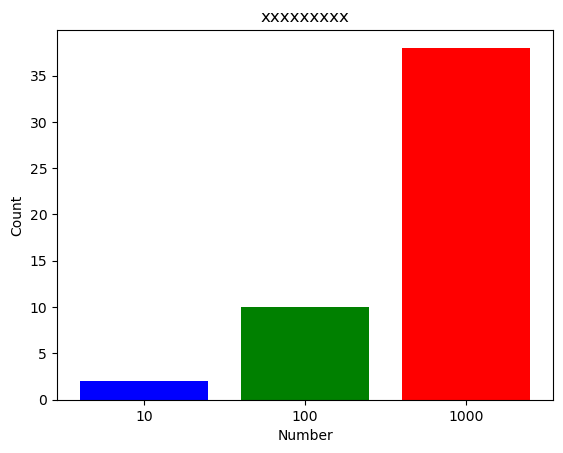

In [7]:
## 参数修正后的TS

## 问题是没有得到最终的策略
def Thompson_Sampling_once(n_arms, n_trials, beta_prio):
  ## 手动都进行+1
  for i in range(n_arms):
    beta_prio[i][0] += 1
    beta_prio[i][1] += 1
  sampled_theta = np.zeros(n_arms)
  reward = np.zeros(n_arms, dtype=int)
  for _ in range(n_trials):
    for i in range(n_arms):
      sampled_theta[i] = np.random.beta(beta_prio[i][0],beta_prio[i][1])
    max_arm = np.argmax(sampled_theta)
    cor_reward = np.random.binomial(1, sampled_theta[max_arm])
    beta_prio[max_arm][0] += cor_reward
    beta_prio[max_arm][1] +=  (1 - cor_reward) 
    reward[max_arm] += cor_reward

  for i in range(n_arms):
    ## final update
    sampled_theta[i] = np.random.beta(beta_prio[i][0],beta_prio[i][1])  
  # print(np.sum(reward))
  return np.sum(reward)       ##, sampled_theta   这里就不输出了

final_reward_para_exp_0 = []
final_reward_para_exp_1 = []
final_reward_para_exp_2 = []


print("I'm calculating, plz wait.")
for i in range(len(theta_seq_set)):
  ## 对第i组theta做500次实验，取平均
  reward_0, reward_1, reward_2 = [], [], []

  ## 5次实验，5000 time slots，否则真有点久
  for j in range(5):
    reward_0.append(Thompson_Sampling_once(3, 5000, para_exp_0[i]))
    reward_1.append(Thompson_Sampling_once(3, 5000, para_exp_1[i]))
    reward_2.append(Thompson_Sampling_once(3, 5000, para_exp_2[i]))
  final_reward_para_exp_0.append(np.mean(np.array(reward_0)))
  final_reward_para_exp_1.append(np.mean(np.array(reward_1)))
  final_reward_para_exp_2.append(np.mean(np.array(reward_2)))


# for i in range(len(theta_seq_set)):
#   print(str(theta_seq_set[i].max_theta * 5000)+" "+str(final_reward_para_exp_0[i])+" "+str(final_reward_para_exp_1[i])+" "+str(final_reward_para_exp_2[i]))
#   print("delta:" + str(final_reward_para_exp_0[i]-theta_seq_set[i].max_theta * 5000) + str(final_reward_para_exp_0[i]-theta_seq_set[i].max_theta * 5000) + str(final_reward_para_exp_0[i]-theta_seq_set[i].max_theta * 5000))

# print(final_reward_para_exp_0)
# print(final_reward_para_exp_1)
# print(final_reward_para_exp_2)
magnitude_performance_static=[]
for i in range(len(theta_seq_set)):
    # 获取格式化的原数值字符串
    values_str = "{:.1f} {:.1f} {:.1f} {:.1f}".format(
        theta_seq_set[i].max_theta * 5000,
        final_reward_para_exp_0[i],
        final_reward_para_exp_1[i],
        final_reward_para_exp_2[i]
    )
    
    # 计算各delta值
    delta_0 = final_reward_para_exp_0[i] - theta_seq_set[i].max_theta * 5000
    delta_1 = final_reward_para_exp_1[i] - theta_seq_set[i].max_theta * 5000
    delta_2 = final_reward_para_exp_2[i] - theta_seq_set[i].max_theta * 5000
    
    # 获取格式化的delta字符串
    delta_str = "delta: {:.1f} {:.1f} {:.1f}".format(delta_0, delta_1, delta_2)
    delta = [abs(delta_0),abs(delta_1),abs(delta_2)]
    # 打印原数值和delta，保证delta字符串右对齐
    print(values_str)
    print(delta_str.rjust(len(values_str)))
    print("Theta-Var: {:.4f}   best-arm: {:1}".format(theta_seq_set[i].var, 1+np.argmin([delta])))
    arm_static.append(1+np.argmin([delta]))
    print()
    ## 统计个数？

# 统计1，2，3的个数
count_1 = arm_static.count(1)
count_2 = arm_static.count(2)
count_3 = arm_static.count(3)

# 打印统计结果
print(f"Count of 1: {count_1}")
print(f"Count of 2: {count_2}")
print(f"Count of 3: {count_3}")

# 准备绘图数据
labels = ['10', '100', '1000']
counts = [count_1, count_2, count_3]

# 绘制条形图
plt.bar(labels, counts, color=['blue', 'green', 'red'])

# 设置标题和标签
plt.xlabel('Number')
plt.ylabel('Count')
plt.title('Proformance Evaluation for 先验个数数量级（10，100，1000）')

# 显示图表
plt.show()
